In [1]:
from mne import read_epochs, set_eeg_reference, concatenate_epochs
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [3]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

load_raw_to_epochs('s1.bdf', True)

Extracting EDF parameters from C:\Users\Alberto\Documents\BCI\data\grg\s1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5201919  =      0.000 ...  2540.000 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



C:\Users\Alberto\Documents\BCI\data\grg\../../preprocessing\load_data.py:35: RuntimeWarning: DigMontage is only a subset of info. There are 8 channel positions not present in the DigMontage. The required channels are:

['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:   22.9s
[Parallel(n_jobs=8)]: Done  72 out of  72 | elapsed:   24.5s finished


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
81 events found
Event IDs: [  2   4 130 134 255]
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 81 events and 20481 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1016 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 3896 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 5913 out of 5913 | elapsed:    8.5s finished


<Epochs |  81 events (all good), -2 - 7.99902 sec, baseline off, ~462.1 MB, data loaded,
 'r_pinch': 16
 'r_stop': 16
 'left': 16
 'right': 16
 'rest': 17>
saved


In [4]:
raw0 = read_epochs('raw_epo.fif')
raw1 = read_epochs('raw1_epo.fif')

raw = concatenate_epochs([raw0, raw1])
raw.save('raw_epo.fif', overwrite=True)

Reading C:\Users\Alberto\Documents\BCI\data\grg\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Alberto\Documents\BCI\data\grg\raw1_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
133 matching events found
No baseline correction applied
Overwriting existing file.


In [10]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\grg\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated


Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 7288 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 9576 out of 9576 | elapsed:    9.2s finished


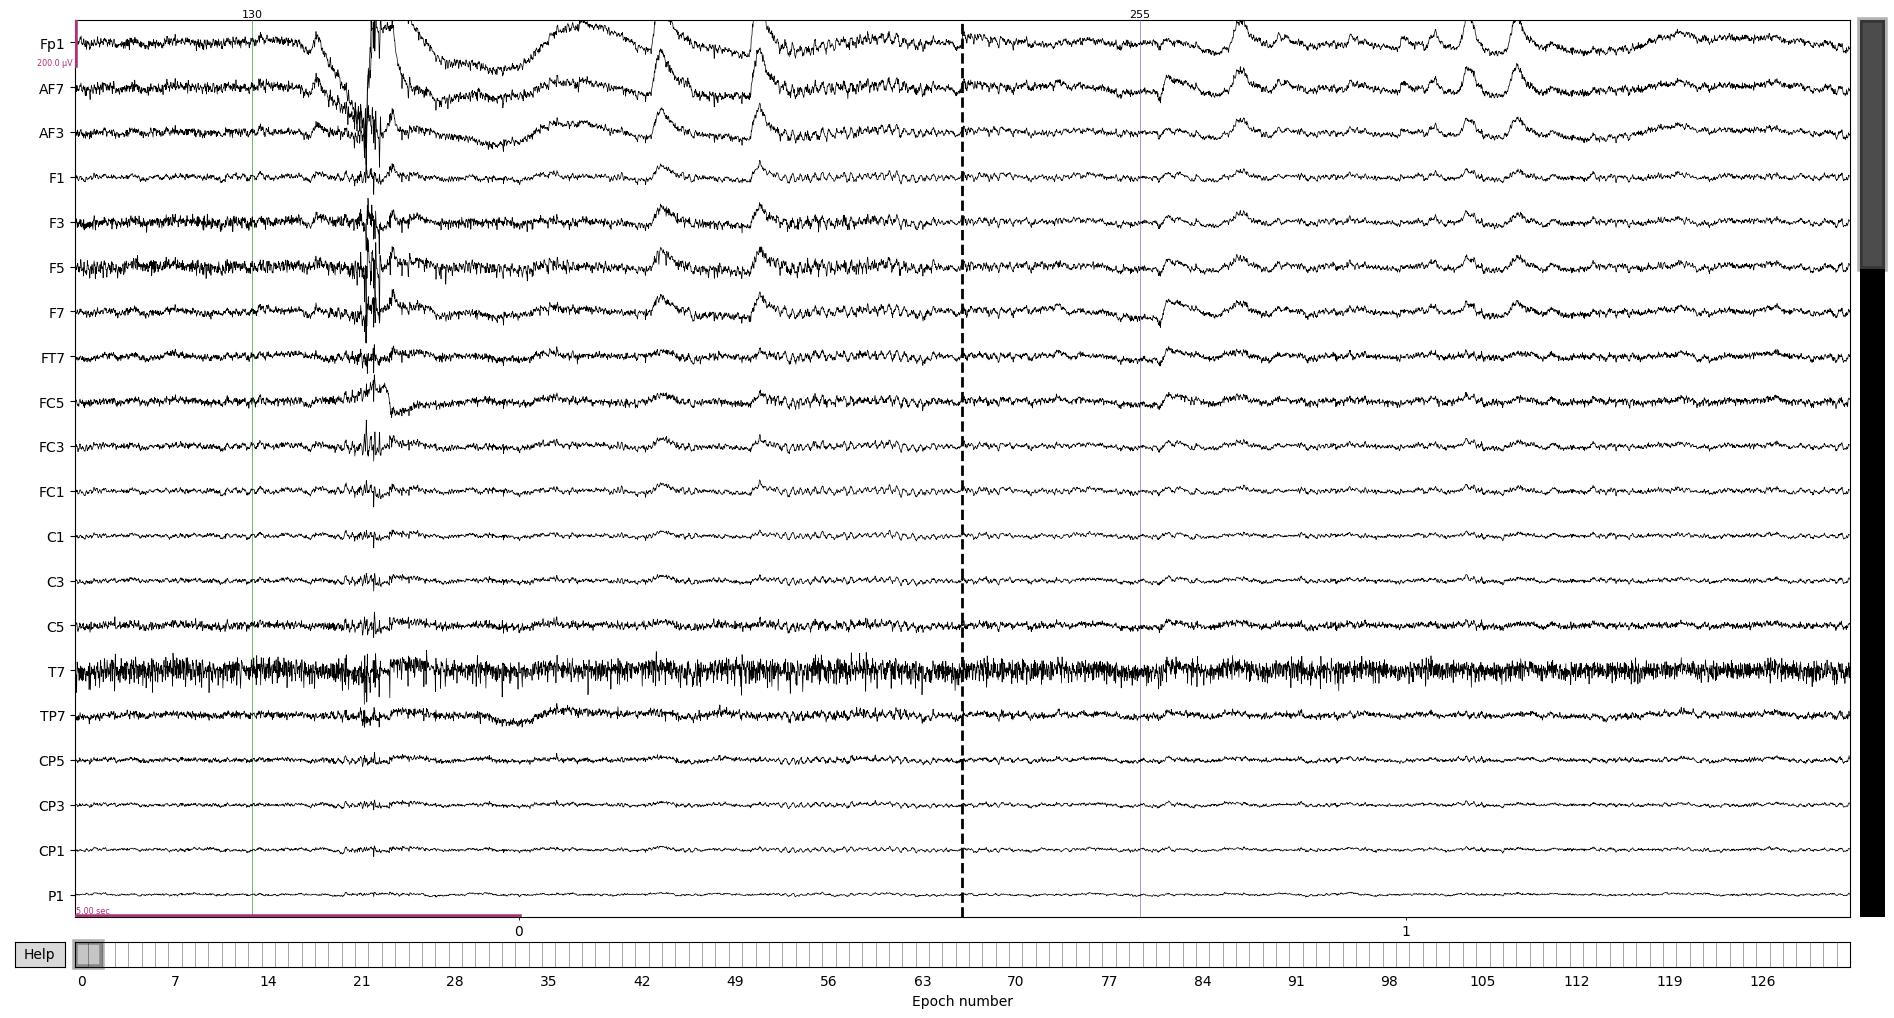

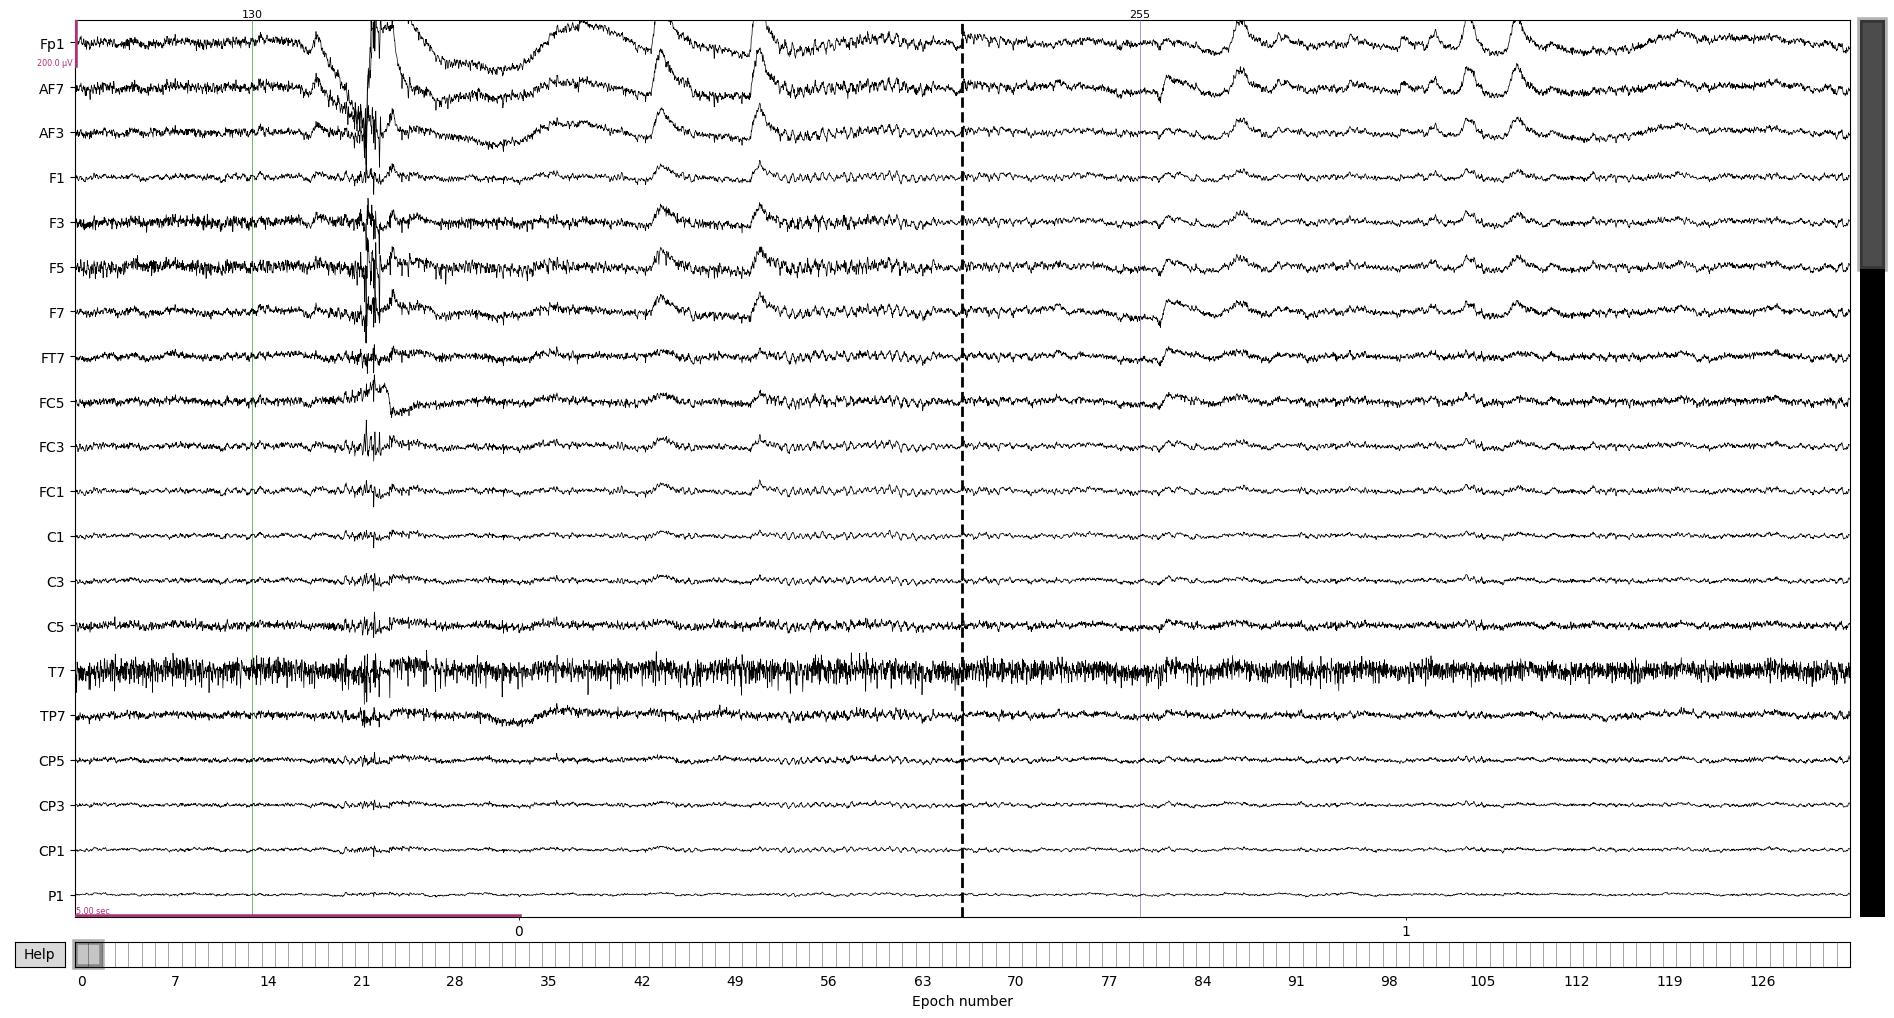

In [25]:
raw.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-5, events=raw.events, picks=['eeg','eog'])

Marking bad chanels

In [11]:
bads =['EXG7','EXG8','T7', 'Iz', 'P2','POz','T8', 'O2', 'P10', 'F6', 'Fp2']
raw.info['bads'] = bads
raw.drop([0, 13, 16, 39, 49, 69, 74, 80, 100, 106, 112, 125])

Dropped 12 epochs: 0, 13, 16, 39, 49, 69, 74, 80, 100, 106, 112, 125


<EpochsFIF |  121 events (all good), -2 - 7.99902 sec, baseline off, ~690.2 MB, data loaded,
 'r_pinch': 22
 'r_stop': 26
 'left': 22
 'right': 26
 'rest': 25>

Referencing

In [12]:
referenced = set_eeg_reference(raw, ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


set channel types

In [13]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  121 events (all good), -2 - 7.99902 sec, baseline off, ~690.2 MB, data loaded,
 'r_pinch': 22
 'r_stop': 26
 'left': 22
 'right': 26
 'rest': 25>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 5776 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 8192 out of 8192 | elapsed:   10.7s finished


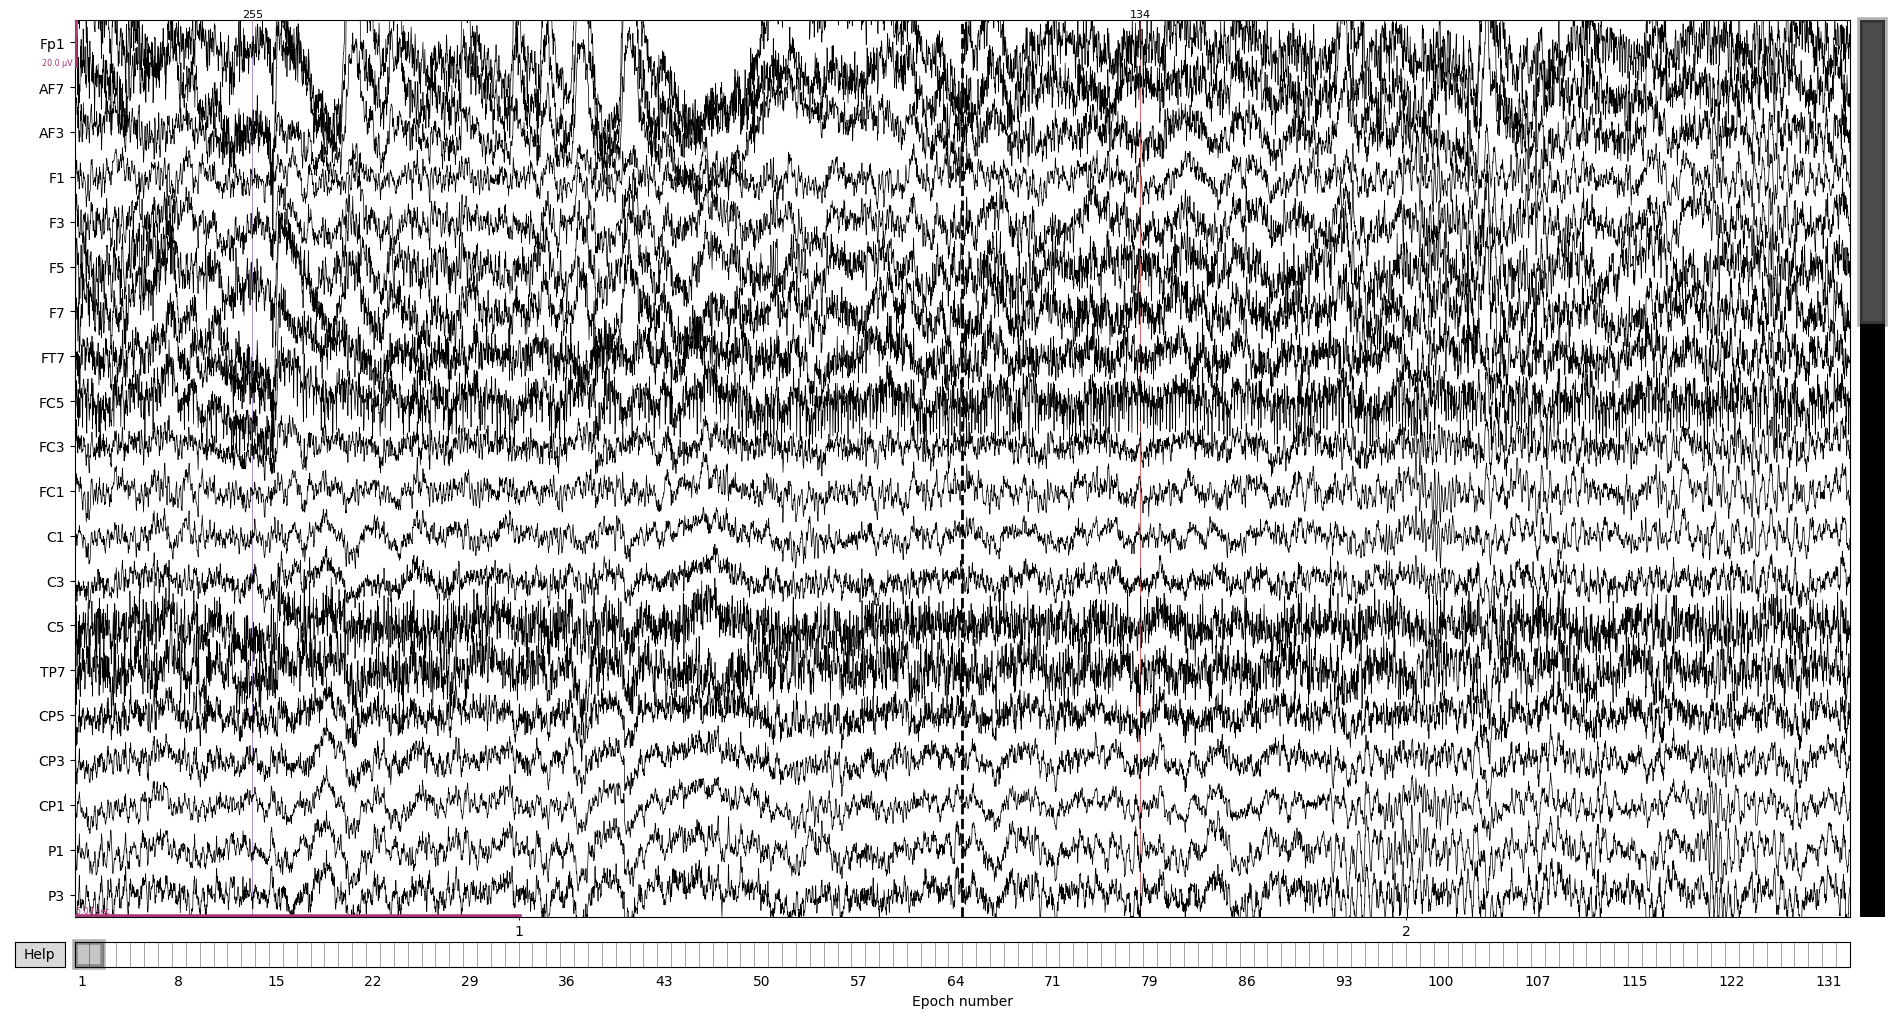

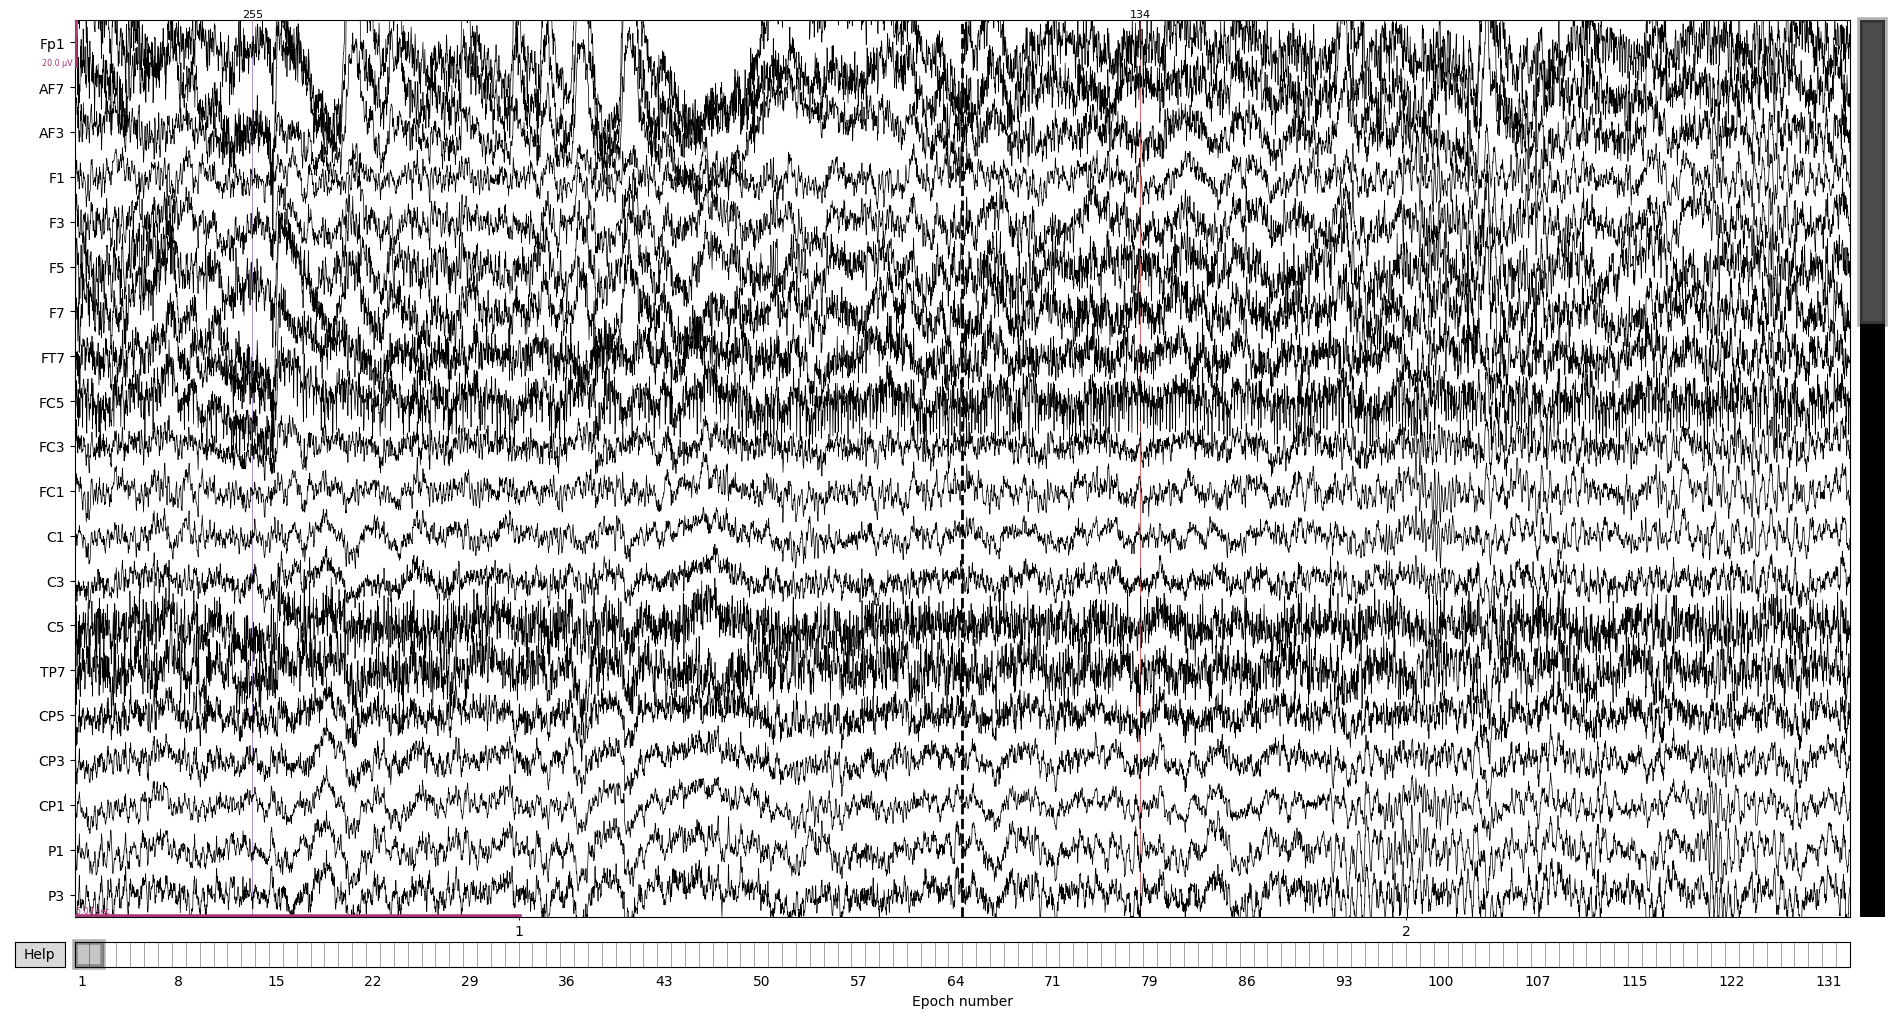

In [29]:
referenced.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=2, scalings=10e-6, events=referenced.events, picks=['eeg','eog'])

EOG regression


No projector specified for this dataset. Please consider the method self.add_proj.


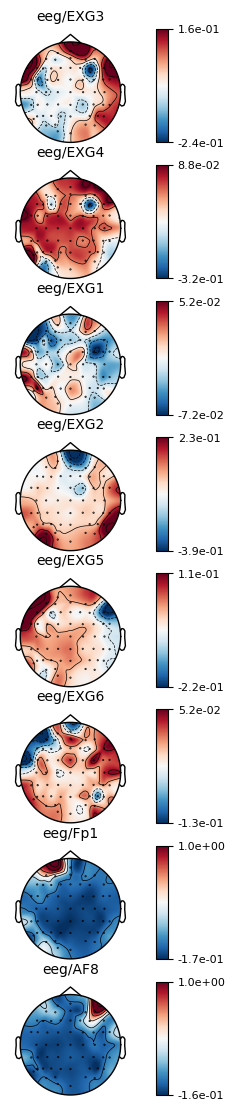

No projector specified for this dataset. Please consider the method self.add_proj.


In [14]:
print()
emg_eog = ['EXG3','EXG4','EXG1','EXG2','EXG5','EXG6','Fp1','AF8']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
referenced = regressor.apply(referenced)
referenced.info['bads'] += ['Fp1','AF8']

In [15]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [17]:
epochs = read_epochs('referenced_epo.fif')
epochs

Reading C:\Users\Alberto\Documents\BCI\data\grg\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  121 events (all good), -2 - 7.99902 sec, baseline off, ~690.2 MB, data loaded,
 'r_pinch': 22
 'r_stop': 26
 'left': 22
 'right': 26
 'rest': 25>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


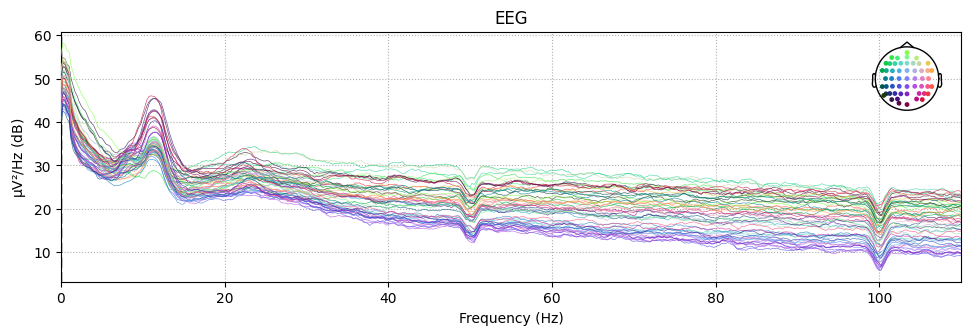

In [18]:
epochs['right'].plot_psd(fmax=110, tmin=0, tmax=4)

EOG Regression

ICA

In [19]:
filtered = epochs['rest','left','right'].copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.5,-0.1))
filtered.crop(-1,1.8)
ica = ICA(n_components=10, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 152 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 2904 tasks      | elapsed:    7.4s


Applying baseline correction (mode: mean)


[Parallel(n_jobs=8)]: Done 4672 out of 4672 | elapsed:    9.3s finished


Fitting ICA to data using 53 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6252\395878811.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by number: 10 components
Fitting ICA took 7.1s.


<ICA | epochs decomposition, method: picard (fit in 30 iterations on 209364 samples), 10 ICA components (53 PCA components available), channel types: eeg, no sources marked for exclusion>

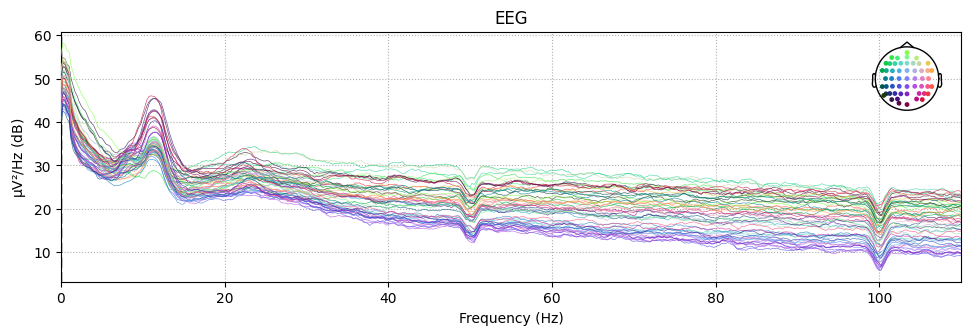

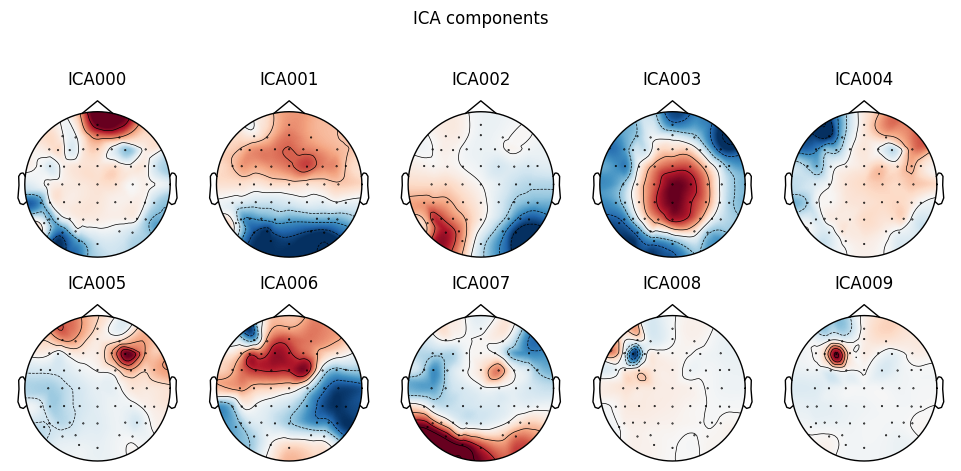

[<MNEFigure size 975x496 with 10 Axes>]

In [20]:
print()
plot_ica_components(ica)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_6252\985191191.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (2356), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right','rest'].copy().crop(-0.5,1.8).filter(1,120, verbose=False),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
73 matching events found
No baseline correction applied
0 projection i

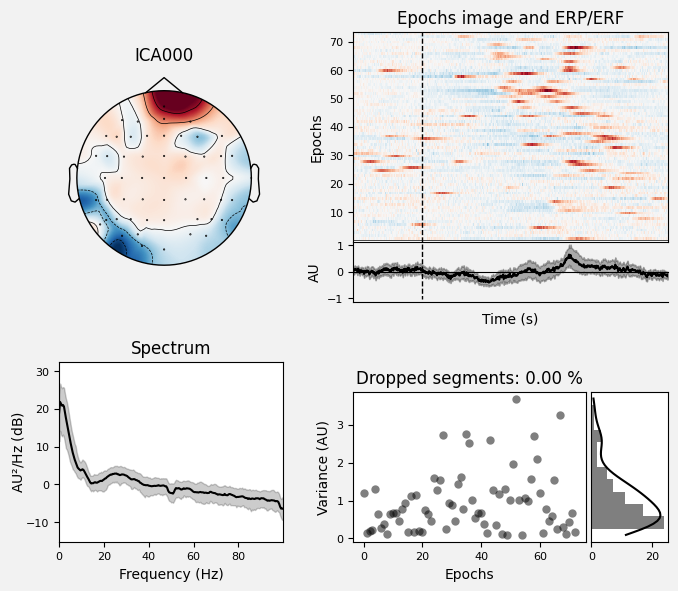

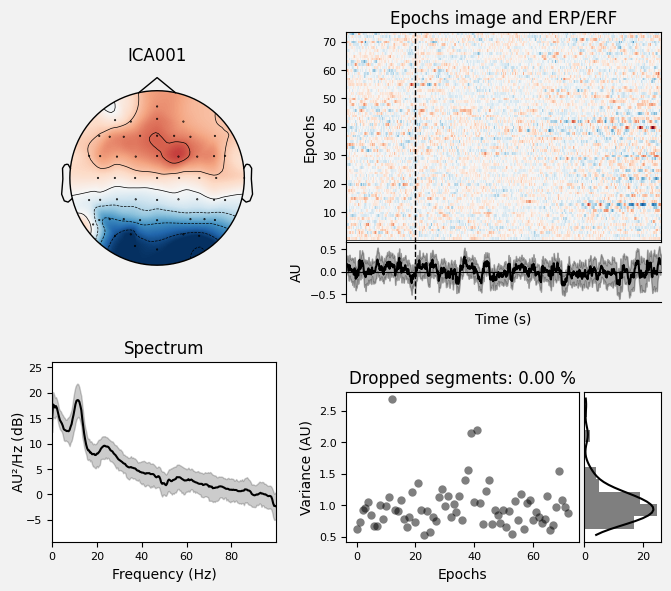

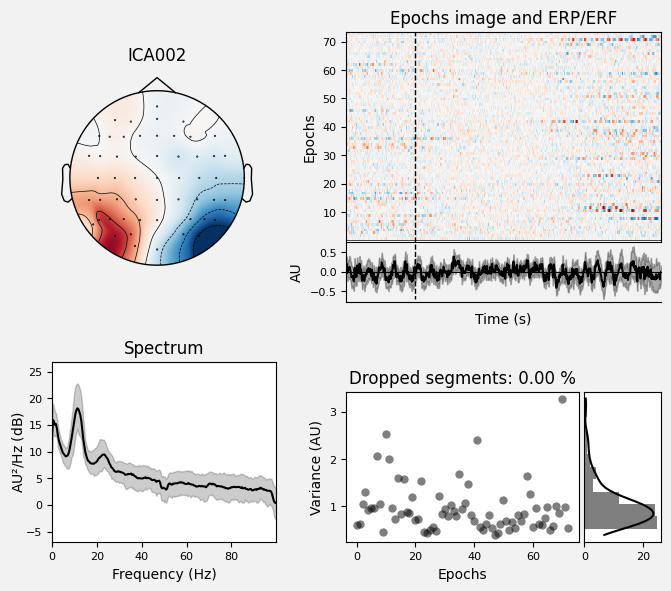

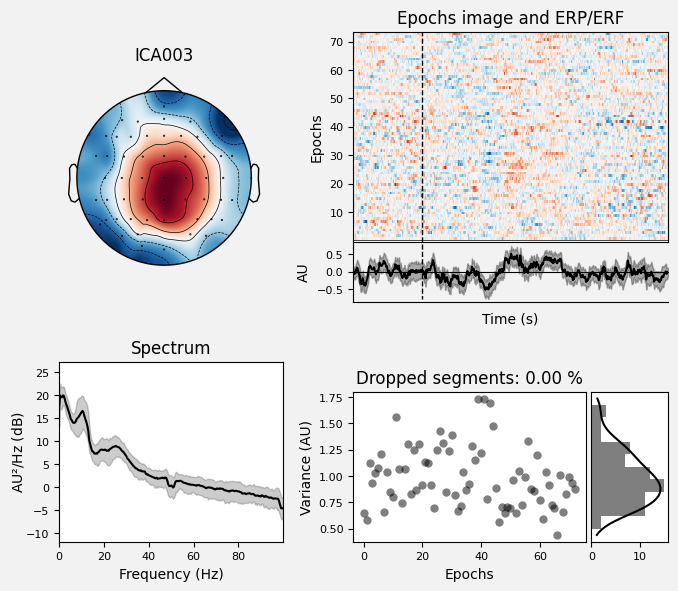

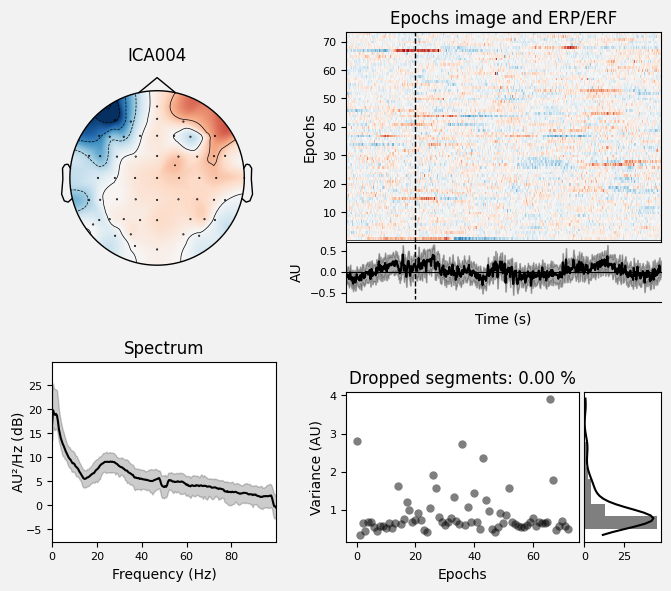

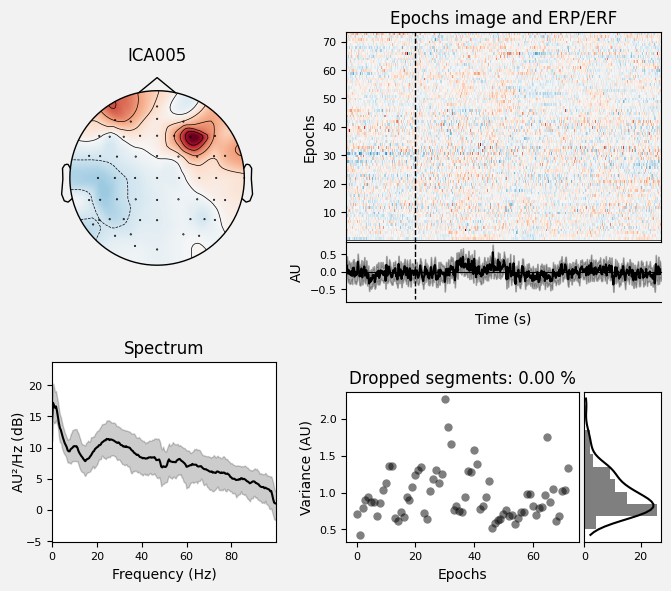

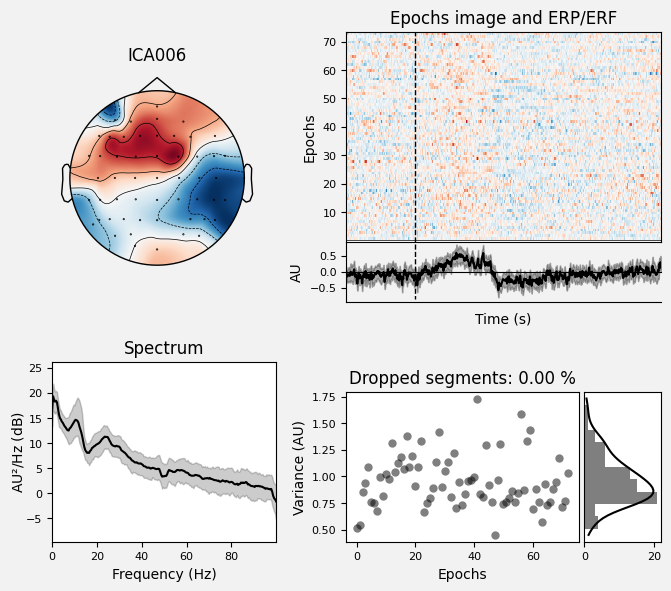

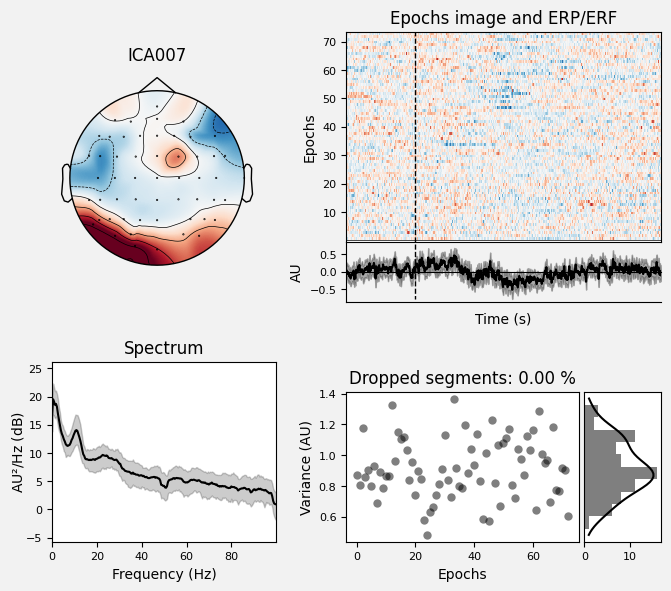

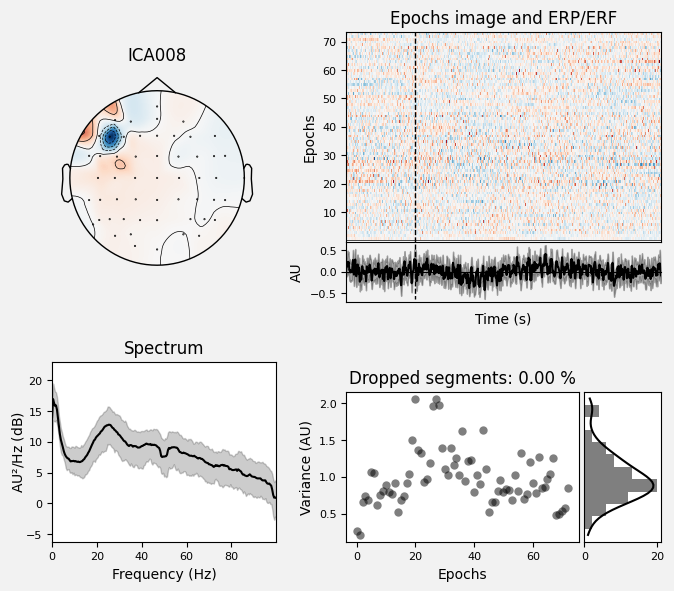

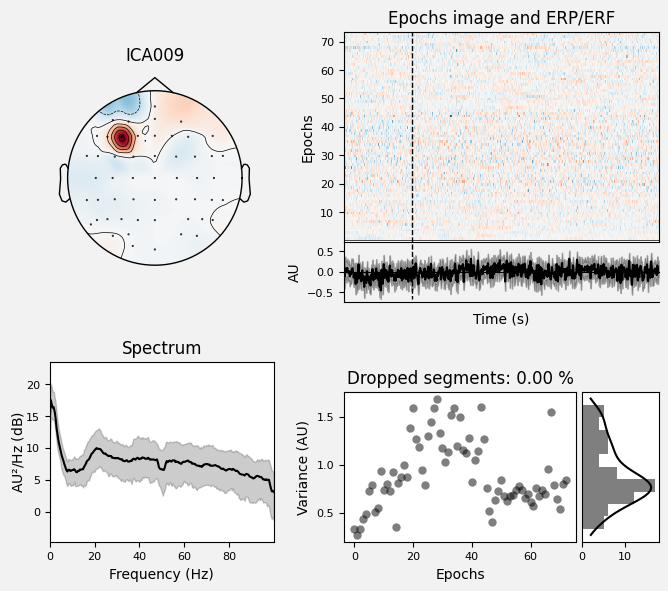

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [24]:
ica.plot_properties(
    epochs['left','right','rest'].copy().crop(-0.5,1.8).filter(1,120, verbose=False), 
    picks = [0,1,2,3,4,5,6,7,8,9], 
    log_scale = False,
    psd_args = dict(fmax=100))

In [22]:
eog_indices, eog_scores = ica.find_bads_eog(
    filtered['left','right','rest'],
    ch_name= emg_eog, 
    measure='zscore',
    threshold=2.)


Using EOG channels: EXG3, EXG4, EXG1, EXG2, EXG5, EXG6, Fp1, AF8


In [23]:
eog_indices


[0, 7]

In [25]:
ica.apply(epochs, exclude=np.unique([0,9]))

Applying ICA to Epochs instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 53 PCA components


<EpochsFIF |  121 events (all good), -2 - 7.99902 sec, baseline off, ~690.2 MB, data loaded,
 'r_pinch': 22
 'r_stop': 26
 'left': 22
 'right': 26
 'rest': 25>

ERP

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_6252\2041666621.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 3072 out of 3072 | elapsed:    1.7s finished


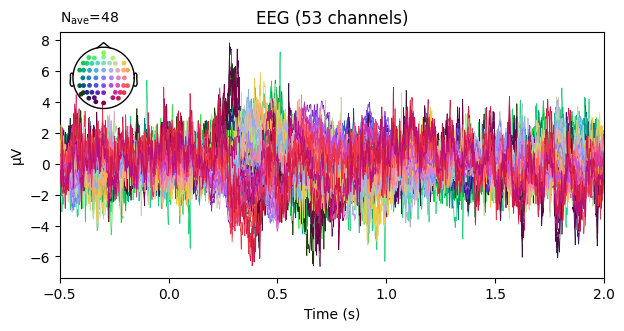

In [26]:
epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_6252\2447180343.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1015 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1593 out of 1600 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.8s finished


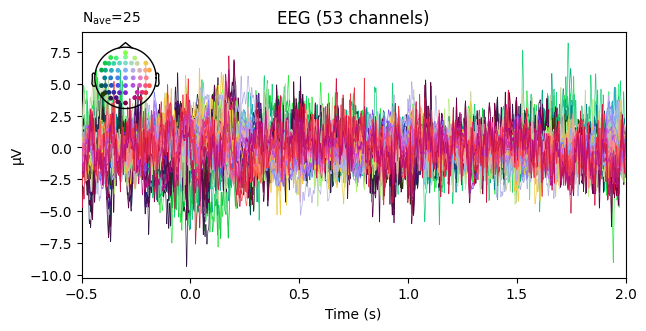

In [27]:
epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
print()

CSP

In [30]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [31]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.


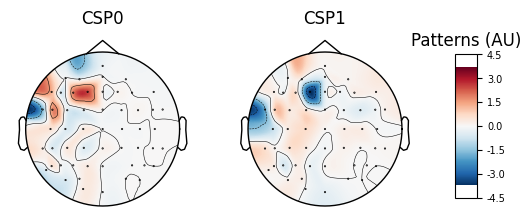

In [32]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.


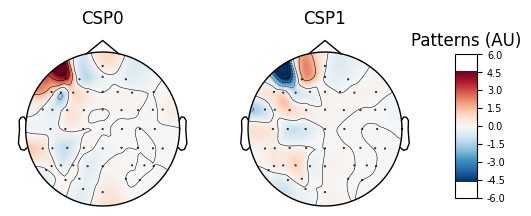

In [33]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 53 after 0 projectors applied to 53 channels
Reducing data rank from 53 -> 53
Estimating covariance using EMPIRICAL
Done.


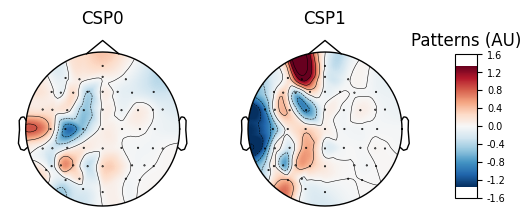

In [34]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [35]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
